In [397]:
import csv
import pandas as pd
from datetime import datetime
from Levenshtein import distance as levenshtein_distance
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
from fitter import Fitter
import itertools
import multiprocessing
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import shapiro
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

In [398]:
events_final = pd.read_csv('truncated_events_final_oneday.csv') 
print(events_final)

       patientid                                    events  \
0       10002013                                     CSURG   
1       10002013                                       ABG   
2       10002013                                       CBC   
3       10002013                                   Calcium   
4       10002013                              Electrolytes   
...          ...                                       ...   
59156   19995790  Chlorhexidine Gluconate 0.12% Oral Rinse   
59157   19995790                           Docusate Sodium   
59158   19995790                                Ranitidine   
59159   19995790                                       CBC   
59160   19995790                              Electrolytes   

                 starttime  
0      2160-05-18 01:49:32  
1      2160-05-18 09:19:00  
2      2160-05-18 09:19:00  
3      2160-05-18 09:19:00  
4      2160-05-18 09:19:00  
...                    ...  
59156  2185-02-02 20:00:00  
59157  2185-02-02 20:00

In [399]:

events_final['starttime'] = pd.to_datetime(events_final['starttime'])

In the next step, we will start to generat the trace

In [400]:

traces = events_final.groupby('patientid')['events'].apply(list).reset_index()
traces['starttimes'] = events_final.groupby('patientid')['starttime'].apply(list).reset_index(drop=True)

In [401]:
print(traces.head())
traces.to_csv('traces.csv', index=False)

   patientid                                             events  \
0   10002013  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
1   10011398  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
2   10023771  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
3   10033786  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
4   10039688  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   

                                          starttimes  
0  [2160-05-18 01:49:32, 2160-05-18 09:19:00, 216...  
1  [2146-12-15 04:53:55, 2146-12-15 07:52:00, 214...  
2  [2113-08-25 03:17:43, 2113-08-25 07:29:00, 211...  
3  [2118-01-16 06:35:16, 2118-01-16 12:00:00, 211...  
4  [2147-05-31 02:31:44, 2147-05-31 07:57:00, 214...  


In [402]:
print(traces['events'].dtype)

object


In [403]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])

['CSURG', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'CBC', 'Electrolytes', 'Glucose', 'Aspirin', 'ABG', 'CBC', 'Electrolytes', 'Glucose', '5% Dextrose', 'Acetaminophen', 'Calcium Gluconate', 'Dextrose 50%', 'Glycopyrrolate', 'Influenza Vaccine', 'Insulin', 'Lactated Ringers', 'Magnesium Sulfate', 'Metoclopramide', 'Milk of Magnesia', 'Neostigmine', 'Nitroglycerin', 'Opioid', 'Oxycodone-Acetaminophen', 'PHENYLEPHrine', 'Pneumococcal Vaccine', 'Potassium Chloride', 'Propofol', 'Sodium Chloride 0.9%', 'Sodium Chloride 0.9%  Flush', 'Sterile Water', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'CBC', 'CefazoLIN', 'Sodium Chloride 0.9%', 'Bicarbonate', 'CBC', 'Creatinine', 'Electrolytes', 'Urea Nitrogen', 'ABG', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'Calcium', 'Electrolytes', 'Glucose', 'Ketorolac', 'ABG', 'Electrolytes', 'Glucose', 'CBC', 'Electrolytes', 'Ondansetron', 'Albumin', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Li

In [404]:
def calculate_hamming_distance(list1, list2, pad_value=None):

    max_len = max(len(list1), len(list2))
    list1_padded = list1 + [pad_value] * (max_len - len(list1))
    list2_padded = list2 + [pad_value] * (max_len - len(list2))
    

    distance = sum(el1 != el2 for el1, el2 in zip(list1_padded, list2_padded))
    return distance

In [405]:

list1 = ['A','B','C','D']
list2 =['A','C','D']


hamming_distance_example = calculate_hamming_distance(list1, list2, pad_value='')
print(f"Hamming distance between list1 and list2: {hamming_distance_example}")

levenshtein_distance_example = levenshtein_distance(list1, list2)
print(f"levenshtein distance between list1 and list2: {levenshtein_distance_example}")

Hamming distance between list1 and list2: 3
levenshtein distance between list1 and list2: 1


In [406]:
first_line = traces.iloc[123]['events']
second_line = traces.iloc[531]['events']
print(traces.iloc[123]['events'])
print(traces.iloc[531]['events'])
print(len(traces.iloc[123]['events']))
print(len(traces.iloc[531]['events']))
hamming_distance_1_2 = calculate_hamming_distance(first_line, second_line)
levenshtein_distance_1_2 = levenshtein_distance(first_line, second_line)
print(f"Hamming distance between the first and second lines: {hamming_distance_1_2}")
print(f"Levenshtein distance between the first and second lines: {levenshtein_distance_1_2}")

['CSURG', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', '5% Dextrose', 'Acetaminophen', 'Aspirin', 'Calcium Gluconate', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Dextrose 50%', 'Docusate Sodium', 'Glycopyrrolate', 'Iso-Osmotic Dextrose', 'Lipid Lowering', 'Magnesium Sulfate', 'Metoclopramide', 'Neostigmine', 'Nitroglycerin', 'Opioid', 'Oxycodone-Acetaminophen', 'PHENYLEPHrine', 'Potassium Chloride', 'Propofol', 'Ranitidine', 'Sodium Chloride 0.9%', 'Sodium Chloride 0.9%  Flush', 'Sterile Water', 'Vancomycin', 'ABG', 'CBC', 'Electrolytes', 'Glucose', '5% Dextrose', 'Insulin', 'Lactated Ringers', 'Pneumococcal Vaccine', 'Sodium Chloride 0.9%', 'ABG', 'CBC', 'Electrolytes', 'Glucose', 'ABG', 'CBC', 'Electrolytes', 'Glucose', 'ABG', 'CBC', 'Electrolytes', 'Glucose', 'CBC', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', '5% Dextrose', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'CefazoLIN', 'Iso-Osmotic Dextrose', 'Bi

In [407]:
num_elements = len(traces)
hamming_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))


for i in range(num_elements):
    for j in range(num_elements):
        hamming_distance = calculate_hamming_distance(traces.at[i, "events"], traces.at[j, "events"])
        hamming_distance_matrix.at[i, j] = hamming_distance


print(hamming_distance_matrix)

    0   1   2   3   4   5   6   7   8   9    ... 837 838 839 840 841 842 843  \
0     0  67  71  70  67  68  61  76  74  78  ...  62  75  69  79  79  63  66   
1    67   0  61  69  68  65  66  64  66  57  ...  62  64  69  80  79  72  62   
2    71  61   0  63  69  64  71  74  60  60  ...  70  68  67  69  75  66  66   
3    70  69  63   0  61  66  61  67  49  64  ...  73  66  56  78  68  55  65   
4    67  68  69  61   0  73  64  65  67  63  ...  71  62  62  74  68  65  65   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
842  63  72  66  55  65  62  70  65  68  71  ...  66  70  57  75  72   0  56   
843  66  62  66  65  65  74  65  71  76  71  ...  71  73  72  76  77  56   0   
844  68  67  60  55  62  71  68  68  60  61  ...  72  57  47  73  63  64  72   
845  79  79  73  68  68  77  78  70  63  61  ...  78  64  64  77  22  71  77   
846  76  62  74  63  66  65  70  32  44  43  ...  64  43  59  79  61  71  76   

    844 845 846  
0    68  79  76  
1  

In [408]:

hamming_row_averages = hamming_distance_matrix.mean(axis=1)
print("Hamming row averages:")
print(hamming_row_averages)

Hamming row averages:
0      72.593861
1      70.641086
2      68.645809
3      66.413223
4      65.871311
         ...    
842    68.060213
843    71.465171
844    64.536009
845     69.38961
846    66.188902
Length: 847, dtype: object


In [409]:

hamming_sorted_row_averages = hamming_row_averages.sort_values(ascending=False)


hamming_reordered_matrix = hamming_distance_matrix.loc[hamming_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(hamming_sorted_row_averages)

print("Reordered Hamming distance matrix:")
print(hamming_reordered_matrix)

Sorted row averages (descending):
416    121.910272
333    108.983471
79     103.011806
440     99.961039
276     98.244392
          ...    
749     63.613932
430     63.459268
627     63.376623
563     63.349469
735     63.340024
Length: 847, dtype: object
Reordered Hamming distance matrix:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
416  124  116  122  115  123  121  118  124  120  120  ...  121  120  121   
333   99  105  105  109  107  110   91  111  113  115  ...  108  112  105   
79   105  105  103  101  107  106  108  104  107  105  ...  106  106  105   
440  102   95   96  102   95   98   93   98  105  101  ...   96  100  101   
276  100   93  101  102   69  102   97   99   99   94  ...   97   91  101   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
749   73   44   55   60   60   76   70   64   50   26  ...   73   52   58   
430   72   55   64   58   52   74   70   64   53   49  ...   70   51   56   
627   71   67

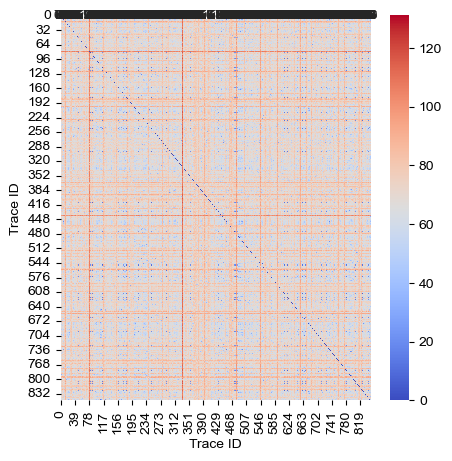

In [410]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure1_Heatmap of Hamming Distance Matrix(24hour).png', format='png', dpi=300)
plt.show()

In [411]:
levenshtein_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))


for i in range(num_elements):
    for j in range(num_elements):
        dist = levenshtein_distance(traces.at[i, "events"], traces.at[j, "events"])
        levenshtein_distance_matrix.at[i, j] = dist


print(levenshtein_distance_matrix)

    0   1   2   3   4   5   6   7   8   9    ... 837 838 839 840 841 842 843  \
0     0  36  32  27  40  32  35  27  30  31  ...  34  45  25  54  68  30  30   
1    36   0  24  33  33  40  43  23  23  28  ...  24  38  37  43  67  36  39   
2    32  24   0  21  30  35  42  17  18  22  ...  18  38  34  37  63  36  39   
3    27  33  21   0  40  30  37  26  25  28  ...  27  40  20  47  57  28  32   
4    40  33  30  40   0  51  52  24  21  26  ...  32  27  42  33  56  47  54   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
842  30  36  36  28  47  26  26  37  36  37  ...  40  47  24  53  61   0  21   
843  30  39  39  32  54  26  27  41  42  41  ...  41  53  27  56  66  21   0   
844  38  32  28  32  15  47  48  20  24  24  ...  32  23  33  35  52  45  51   
845  68  63  61  54  56  62  70  59  53  51  ...  62  55  54  65  10  58  64   
846  34  25  22  25  27  43  46  15  14  15  ...  26  30  28  43  50  38  45   

    844 845 846  
0    38  68  34  
1  

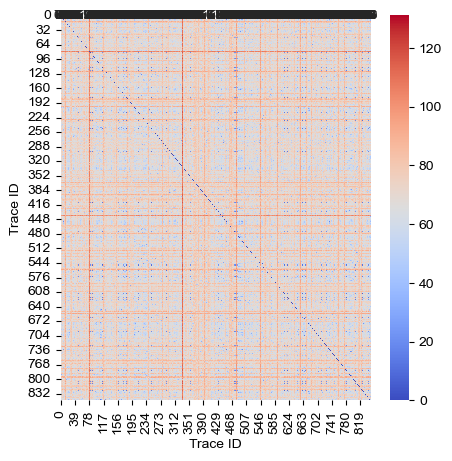

In [412]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure2_Heatmap of Levenshtein Distance Matrix(24hour).png', format='png', dpi=300)
plt.show()

In [413]:

levenshtein_row_averages = levenshtein_distance_matrix.mean(axis=1)


print("Levenshtein row averages:")
print(levenshtein_row_averages)

Levenshtein row averages:
0       40.83353
1      39.571429
2      35.775679
3      37.330579
4      35.916175
         ...    
842    42.177096
843    45.763872
844     33.83353
845    57.878394
846     34.70366
Length: 847, dtype: object


In [414]:
levenshtein_averages = levenshtein_row_averages.tolist()
levenshtein_averages = pd.DataFrame(levenshtein_row_averages, columns=['variation distance'])

print("Levenshtein averages:")
print(levenshtein_averages)

Levenshtein averages:
    variation distance
0             40.83353
1            39.571429
2            35.775679
3            37.330579
4            35.916175
..                 ...
842          42.177096
843          45.763872
844           33.83353
845          57.878394
846           34.70366

[847 rows x 1 columns]


In [415]:

levenshtein_sorted_row_averages = levenshtein_row_averages.sort_values(ascending=False)


levenshtein_reordered_matrix = levenshtein_distance_matrix.loc[levenshtein_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(levenshtein_sorted_row_averages)

print("Reordered Levenshtein distance matrix:")
print(levenshtein_reordered_matrix)

Sorted row averages (descending):
416     89.35183
333    72.069658
94     69.844156
299    69.543093
440    67.649351
         ...    
202    32.787485
297    32.650531
243    32.634002
497    32.593861
697    32.184179
Length: 847, dtype: object
Reordered Levenshtein distance matrix:
    0   1   2   3   4   5   6   7   8   9    ... 837 838 839 840  841 842 843  \
416  85  76  78  85  94  87  90  88  86  87  ...  73  88  90  90  115  88  85   
333  54  64  61  57  81  60  58  69  68  69  ...  62  80  60  79  106  58  55   
94   79  79  75  68  68  77  78  70  63  61  ...  79  65  64  81   19  72  78   
299  78  78  75  67  67  77  78  70  62  61  ...  79  65  64  81   19  72  78   
440  64  65  62  70  63  66  68  67  68  68  ...  61  63  71  58   96  66  64   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ...  ..  ..   
202  24  26  21  18  28  36  37  14  13  15  ...  27  30  19  44   53  29  36   
297  31  24  19  24  24  37  44  14  11  14  ...  22  25  25  39 

In [416]:
temp_distance = levenshtein_sorted_row_averages.reset_index(drop=True)

top_2_5_percentile = np.percentile(temp_distance, 97.5)
top_5_percentile = np.percentile(temp_distance, 95)
top_10_percentile = np.percentile(temp_distance, 90)
top_20_percentile = np.percentile(temp_distance, 80)
bottom_20_percentile = np.percentile(temp_distance, 20)

print(f"Top 2.5% of the list is above: {top_2_5_percentile}")
print(f"22 th: {levenshtein_sorted_row_averages[21]}")
print(f"Top 5% of the list is above: {top_5_percentile}")
print(f"Top 10% of the list is above: {top_10_percentile}")
print(f"Top 20% of the list is above: {top_20_percentile}")
print(f"Bottom 20% of the list is below: {bottom_20_percentile}")

Top 2.5% of the list is above: 60.58600944510036
22 th: 34.10507674144038
Top 5% of the list is above: 58.88417945690673
Top 10% of the list is above: 53.67981109799292
Top 20% of the list is above: 47.100826446281
Bottom 20% of the list is below: 36.68925619834711


In [417]:
if not levenshtein_sorted_row_averages.index.equals(hamming_sorted_row_averages.index):
    levenshtein_sorted_row_averages_positions = pd.Series(levenshtein_sorted_row_averages.index, name='levenshtein_sorted_row_averages_index')
    hamming_sorted_row_averages_positions = pd.Series(hamming_sorted_row_averages.index, name='hamming_sorted_row_averages_index')

    comparison_df = pd.DataFrame({'levenshtein_sorted_row_averages_position': levenshtein_sorted_row_averages_positions, 'hamming_sorted_row_averages_position': hamming_sorted_row_averages_positions})
    mismatched_positions = comparison_df[levenshtein_sorted_row_averages_positions != hamming_sorted_row_averages_positions]
    display(comparison_df)  
    print("Mismatched indexes and their positions:")
    display(mismatched_positions)  
else:
    print("Both DataFrames have the same index order.")

,levenshtein_sorted_row_averages_position,hamming_sorted_row_averages_position
0,416,416
1,333,333
2,94,79
3,299,440
4,440,276
...,...,...
842,202,749
843,297,430
844,243,627
845,497,563


Mismatched indexes and their positions:


,levenshtein_sorted_row_averages_position,hamming_sorted_row_averages_position
2,94,79
3,299,440
4,440,276
5,309,214
6,79,460
...,...,...
842,202,749
843,297,430
844,243,627
845,497,563


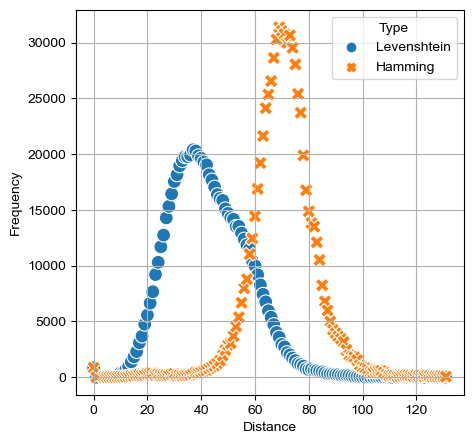

In [418]:
lev_distances = levenshtein_distance_matrix.values.flatten()
ham_distances = hamming_distance_matrix.values.flatten()

lev_unique_distances, lev_counts = np.unique(lev_distances, return_counts=True)
ham_unique_distances, ham_counts = np.unique(ham_distances, return_counts=True)

lev_distance_freq_df = pd.DataFrame({'Distance': lev_unique_distances, 'Frequency': lev_counts, 'Type': 'Levenshtein'})
ham_distance_freq_df = pd.DataFrame({'Distance': ham_unique_distances, 'Frequency': ham_counts, 'Type': 'Hamming'})

distance_freq_df = pd.concat([lev_distance_freq_df, ham_distance_freq_df])


plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=distance_freq_df, x='Distance', y='Frequency', hue='Type', style='Type', s=100)

#plt.title('Frequency Distributions of Hamming and Levenshtein Distance Measurements(48hour)', fontsize=12, fontweight='bold')
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.savefig('eFigure3_Frequency Distributions of Hamming and Levenshtein Distance Measurements(24hour).png', bbox_inches='tight',format='png', dpi=300)
plt.grid(True)
plt.show()

In [419]:
#Select the top 2.5% and bottom 2.5% lists
top_2_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.025))
bottom_2_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.975))

top_2_percent_lists = levenshtein_reordered_matrix.iloc[:top_2_percent_index]
bottom_2_percent_lists = levenshtein_reordered_matrix.iloc[bottom_2_percent_index:]

In [420]:
# Select the top 5% and bottom 5% lists
top_5_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.05))
bottom_5_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.95))

top_5_percent_lists = levenshtein_reordered_matrix.iloc[:top_5_percent_index]
bottom_5_percent_lists = levenshtein_reordered_matrix.iloc[bottom_5_percent_index:]

In [421]:
# Select the top 10% and bottom 10% lists
top_10_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.10))
bottom_10_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.90))

top_10_percent_lists = levenshtein_reordered_matrix.iloc[:top_10_percent_index]
bottom_10_percent_lists = levenshtein_reordered_matrix.iloc[bottom_10_percent_index:]

In [422]:
# Select the top 20% and bottom 20% lists
top_20_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.20))
bottom_20_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.80))

top_20_percent_lists = levenshtein_reordered_matrix.iloc[:top_20_percent_index]
bottom_20_percent_lists = levenshtein_reordered_matrix.iloc[bottom_20_percent_index:]

In [423]:
print("Top 2.5% lists:")
print(top_2_percent_lists)
print("Bottom 2.5% lists:")
print(bottom_2_percent_lists)

top_2_percent_index = top_2_percent_lists.index.tolist()
print("PatientID of Top 2.5% traces:")
print(top_2_percent_lists.index.tolist())
bottom_2_percent_index = bottom_2_percent_lists.index.tolist()
print("PatientID of Bottom 2.5% traces:")
print(bottom_2_percent_lists.index.tolist())

Top 2.5% lists:
    0   1   2   3   4   5   6   7   8   9    ... 837 838 839 840  841 842 843  \
416  85  76  78  85  94  87  90  88  86  87  ...  73  88  90  90  115  88  85   
333  54  64  61  57  81  60  58  69  68  69  ...  62  80  60  79  106  58  55   
94   79  79  75  68  68  77  78  70  63  61  ...  79  65  64  81   19  72  78   
299  78  78  75  67  67  77  78  70  62  61  ...  79  65  64  81   19  72  78   
440  64  65  62  70  63  66  68  67  68  68  ...  61  63  71  58   96  66  64   
309  76  76  73  66  64  74  74  67  60  58  ...  76  62  62  79   18  69  75   
79   57  61  57  58  65  49  60  63  68  70  ...  63  71  53  75   95  53  52   
411  72  71  69  62  61  67  73  63  56  54  ...  73  58  58  73   13  64  69   
661  72  70  67  60  61  67  72  63  56  54  ...  70  59  58  72   10  63  69   
547  71  70  67  61  59  68  71  61  55  53  ...  71  57  57  73   12  64  70   
611  71  70  67  61  60  69  73  61  55  52  ...  72  57  57  73   13  63  69   
550  72  69 

In [424]:
complete_patients_clinical = pd.read_csv('completepatients.csv')
complete_patients = pd.concat([complete_patients_clinical,levenshtein_averages], axis=1)
print(complete_patients.head())

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  \
0         SINGLE                   1                         1  ...   
1        MARRIED                   0                         0  ...   
2        MARRIED                   0                         0  ...   
3        MARRIED                   0                         0  ...   
4        MARRIED                   1                         0  ...   

   renal_disease  malignant_cancer  severe_liver_disease  \
0              0                 0          

In [425]:
#print(complete_patients.dtypes)
complete_patients['distance'] = pd.to_numeric(complete_patients['variation distance'], errors='coerce')

In [426]:
complete_patients['age_group'] = pd.cut(complete_patients['age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100],
                         labels=['20-30', '31-40', '41-50', '51-60', '61-70','71-80','81-90','91-100'])

In [427]:
def categorize_cci(cci):
    if 10 <= cci <= 12:
        return '10-12'
    elif 8 <= cci < 10:
        return '8-10'
    elif 6 <= cci < 8:
        return '6-8'
    elif 4 <= cci < 6:  
        return '4-6'
    elif 2 <= cci < 4:  
        return '2-4'
    elif 0 <= cci < 2:
        return '0-2'
complete_patients['cci_group'] = complete_patients['cci'].apply(categorize_cci)

In [428]:
def categorize_distance(distance):
    if distance >= 47.10:  
        return 'top20%'
    else:
        return 'Other'
complete_patients['distance_group'] = complete_patients['distance'].apply(categorize_distance)

In [429]:
print(complete_patients.head())
#complete_patients.to_csv('test.csv',index = False)
value_counts = complete_patients['distance_group'].value_counts()
print(value_counts)

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  aids  \
0         SINGLE                   1                         1  ...     0   
1        MARRIED                   0                         0  ...     0   
2        MARRIED                   0                         0  ...     0   
3        MARRIED                   0                         0  ...     0   
4        MARRIED                   1                         0  ...     0   

   cci  in_hospital_mortality  died_within_30_days  length_of_stay  

In [430]:
complete_patients['race'] = complete_patients['race'].str.split(' ').str[0]
complete_patients['race']= complete_patients['race'].replace(['BLACK/AFRICAN', 'BLACK/CARIBBEAN','BLACK/CAPE','HISPANIC/LATINO','HISPANIC','PATIENT', 'UNABLE','SOUTH','PORTUGUESE','MULTIPLE','OTHER','ASIAN','UNKNOWN'], 'OTHER')
value_counts_race = complete_patients['race'].value_counts()
print(value_counts_race)

race
WHITE    667
OTHER    180
Name: count, dtype: int64


In [431]:
value_counts_gender = complete_patients['gender'].value_counts()
print(value_counts_gender)
value_counts_insurance = complete_patients['insurance'].value_counts()
print(value_counts_insurance)

gender
M    701
F    146
Name: count, dtype: int64
insurance
Other       506
Medicare    313
Medicaid     28
Name: count, dtype: int64


In [432]:
y = complete_patients['length_of_stay']
model = smf.ols('y ~ distance_group + age + cci + C(gender) + C(insurance) + C(race)', data=complete_patients).fit()
print(model.summary())
residuals = model.resid
exog = model.model.exog
s, p = shapiro(residuals)
print('Shapiro-Wilk p:', p)
breuschpagan_test = het_breuschpagan(residuals, exog)
name = ['lm', 'lm_pvalue', 'fvalue', 'f_pvalue']
print(dict(zip(name, breuschpagan_test)))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     18.17
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           1.36e-22
Time:                        18:32:30   Log-Likelihood:                -4774.9
No. Observations:                 847   AIC:                             9566.
Df Residuals:                     839   BIC:                             9604.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [433]:
gamma_model = smf.glm(
    formula='length_of_stay ~ distance_group + age + cci + C(gender) + C(insurance) + C(race)',
    data=complete_patients,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()

print(gamma_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         length_of_stay   No. Observations:                  847
Model:                            GLM   Df Residuals:                      839
Model Family:                   Gamma   Df Model:                            7
Link Function:                    log   Scale:                         0.18658
Method:                          IRLS   Log-Likelihood:                -4454.7
Date:                Mon, 21 Jul 2025   Deviance:                       92.889
Time:                        18:32:30   Pearson chi2:                     157.
No. Iterations:                    12   Pseudo R-squ. (CS):             0.1598
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [434]:
np.exp(gamma_model.params)

Intercept                   161.123164
distance_group[T.top20%]      1.225376
C(gender)[T.M]                0.950598
C(insurance)[T.Medicare]      0.810126
C(insurance)[T.Other]         0.762623
C(race)[T.WHITE]              0.967939
age                           0.997751
cci                           1.071083
dtype: float64

In [435]:
np.exp(gamma_model.conf_int())

,0,1
Intercept,121.542968,213.592562
distance_group[T.top20%],1.138263,1.319157
C(gender)[T.M],0.878942,1.028095
C(insurance)[T.Medicare],0.682066,0.962231
C(insurance)[T.Other],0.645502,0.900995
C(race)[T.WHITE],0.899869,1.041158
age,0.993893,1.001625
cci,1.051746,1.090774


1.3380722619430523e-14


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


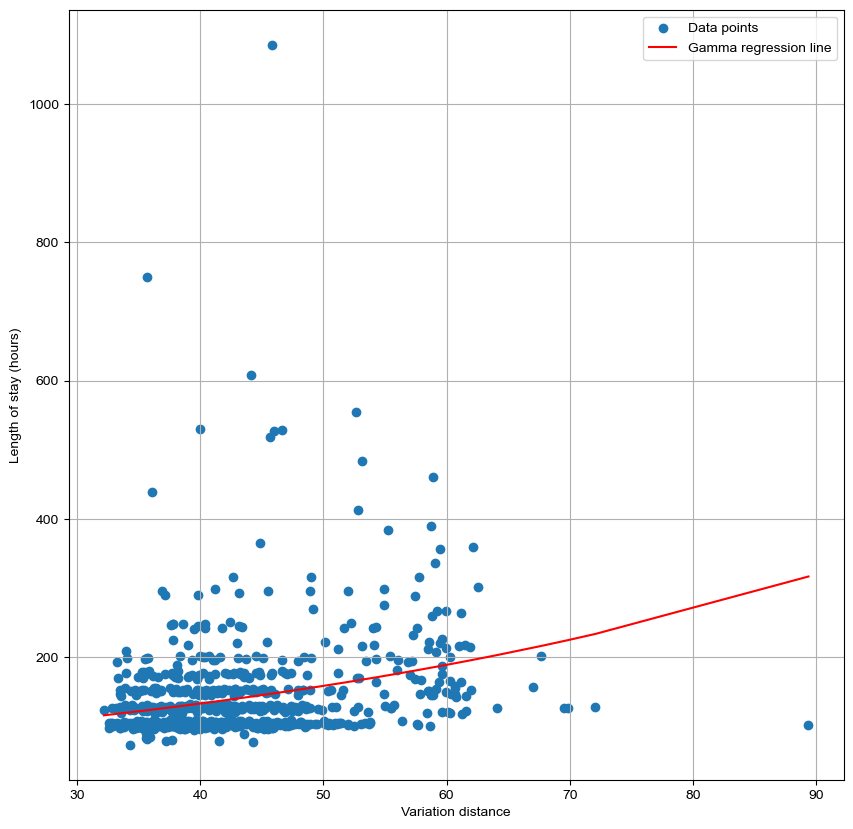

In [436]:
x = complete_patients['variation distance'].astype(float).values
#y = (complete_patients['length_of_stay'].astype(float) / 24).values

y = complete_patients['length_of_stay'].astype(float).values

X = sm.add_constant(x)

gamma_model = sm.GLM(y, X, family=sm.families.Gamma(sm.families.links.log()))
gamma_results = gamma_model.fit()


x_sorted = np.sort(x)
X_sorted = sm.add_constant(x_sorted)
y_pred = gamma_results.predict(X_sorted)


null_model = sm.GLM(y, np.ones((len(y), 1)), family=sm.families.Gamma(sm.families.links.log())).fit()
pseudo_r2 = 1 - gamma_results.deviance / null_model.deviance


p_value = gamma_results.pvalues[1]
print(p_value)

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x, y,label='Data points')
plt.plot(x_sorted, y_pred, color='red', label='Gamma regression line')

plt.xlabel('Variation distance', fontsize=10)
plt.ylabel('Length of stay (hours)', fontsize=10)
plt.grid(True)

plt.legend()
plt.savefig('Figure_Relationship Between Variation and Length of Stay_24-hour.png',
            bbox_inches='tight', format='png', dpi=800)
plt.show()

In [437]:
print(complete_patients.columns)

Index(['subject_id', 'hadm_id', 'age', 'gender', 'insurance', 'language',
       'race', 'marital_status', 'myocardial_infarct',
       'congestive_heart_failure', 'peripheral_vascular_disease',
       'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
       'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
       'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia',
       'renal_disease', 'malignant_cancer', 'severe_liver_disease',
       'metastatic_solid_tumor', 'aids', 'cci', 'in_hospital_mortality',
       'died_within_30_days', 'length_of_stay', 'variation distance',
       'distance', 'age_group', 'cci_group', 'distance_group'],
      dtype='object')


In [438]:
top_2_percent = complete_patients.loc[top_2_percent_index]
print(top_2_percent)
output_path = 'top_2_percent.csv'
top_2_percent.to_csv(output_path, index=False)
top_2_percent_los = top_2_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_2_percent_los}")
top_2_percent_in_hospital_mortality = top_2_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_2_percent_in_hospital_mortality}")
top_2_percent_30_day_mortality = top_2_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_2_percent_30_day_mortality}")
top_2_percent_cci =top_2_percent['cci'].mean()
print(f"The average of CCI is: {top_2_percent_cci}")
top_2_percent_top3cci_averages = top_2_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_2_percent_top3cci = top_2_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_2_percent_top3cci)

     subject_id   hadm_id  age gender insurance language   race  \
416    15156174  27191368   51      M     Other  ENGLISH  WHITE   
333    14195255  27013153   74      M  Medicare  ENGLISH  WHITE   
94     11162509  29912299   69      M     Other  ENGLISH  WHITE   
299    13963514  24742780   49      M     Other  ENGLISH  WHITE   
440    15417736  23735688   62      F  Medicare  ENGLISH  OTHER   
309    14015770  20739167   65      M     Other  ENGLISH  OTHER   
79     11047016  22671173   75      M  Medicare  ENGLISH  WHITE   
411    15058789  21706033   65      M  Medicare  ENGLISH  WHITE   
661    17773753  21526706   62      M     Other  ENGLISH  WHITE   
547    16572462  24120781   61      M     Other  ENGLISH  WHITE   
611    17325365  22458966   46      M     Other  ENGLISH  WHITE   
550    16586569  27860825   75      M  Medicare        ?  WHITE   
180    12392789  21327499   77      M  Medicare  ENGLISH  WHITE   
121    11561996  25938077   45      F  Medicare  ENGLISH  WHIT

In [439]:
# Display the top 5% lists
print("Top 5% lists:")
print(top_5_percent_lists)

# Display the bottom 5% lists
print("Bottom 5% lists:")
print(bottom_5_percent_lists)

top_5_percent_index = top_5_percent_lists.index.tolist()
print("PatientID of Top 5% traces:")
print(top_5_percent_lists.index.tolist())
bottom_5_percent_index = bottom_5_percent_lists.index.tolist()
print("PatientID of Bottom 5% traces:")
print(bottom_5_percent_lists.index.tolist())

Top 5% lists:
    0   1   2   3   4   5   6   7   8   9    ... 837 838 839 840  841 842 843  \
416  85  76  78  85  94  87  90  88  86  87  ...  73  88  90  90  115  88  85   
333  54  64  61  57  81  60  58  69  68  69  ...  62  80  60  79  106  58  55   
94   79  79  75  68  68  77  78  70  63  61  ...  79  65  64  81   19  72  78   
299  78  78  75  67  67  77  78  70  62  61  ...  79  65  64  81   19  72  78   
440  64  65  62  70  63  66  68  67  68  68  ...  61  63  71  58   96  66  64   
309  76  76  73  66  64  74  74  67  60  58  ...  76  62  62  79   18  69  75   
79   57  61  57  58  65  49  60  63  68  70  ...  63  71  53  75   95  53  52   
411  72  71  69  62  61  67  73  63  56  54  ...  73  58  58  73   13  64  69   
661  72  70  67  60  61  67  72  63  56  54  ...  70  59  58  72   10  63  69   
547  71  70  67  61  59  68  71  61  55  53  ...  71  57  57  73   12  64  70   
611  71  70  67  61  60  69  73  61  55  52  ...  72  57  57  73   13  63  69   
550  72  69  6

In [440]:
# Display the top 10% lists
print("Top 10% lists:")
print(top_10_percent_lists)

# Display the bottom 10% lists
print("Bottom 10% lists:")
print(bottom_10_percent_lists)

top_10_percent_index = top_10_percent_lists.index.tolist()
print("PatientID of Top 10% traces:")
print(top_10_percent_lists.index.tolist())
bottom_10_percent_index = bottom_10_percent_lists.index.tolist()
print("PatientID of Bottom 10% traces:")
print(bottom_10_percent_lists.index.tolist())

Top 10% lists:
    0   1   2   3   4   5   6   7   8   9    ... 837 838 839 840  841 842 843  \
416  85  76  78  85  94  87  90  88  86  87  ...  73  88  90  90  115  88  85   
333  54  64  61  57  81  60  58  69  68  69  ...  62  80  60  79  106  58  55   
94   79  79  75  68  68  77  78  70  63  61  ...  79  65  64  81   19  72  78   
299  78  78  75  67  67  77  78  70  62  61  ...  79  65  64  81   19  72  78   
440  64  65  62  70  63  66  68  67  68  68  ...  61  63  71  58   96  66  64   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ...  ..  ..   
295  61  60  59  55  46  64  71  51  47  45  ...  56  46  58  54   68  66  66   
271  41  49  41  42  63  31  45  47  52  54  ...  41  63  38  58   83  38  39   
171  40  50  49  43  60  36  43  51  53  51  ...  49  60  35  62   74  37  36   
228  54  47  48  54  43  59  63  49  50  49  ...  46  50  60  47   79  61  65   
673  34  51  47  42  57  41  41  46  47  50  ...  50  56  32  67   76  37  33   

    844  845

In [441]:
# Display the top 20% lists
print("Top 20% lists:")
print(top_20_percent_lists)

# Display the bottom 20% lists
print("Bottom 20% lists:")
print(bottom_20_percent_lists)

top_20_percent_index = top_20_percent_lists.index.tolist()
print("PatientID of Top 20% traces:")
print(top_20_percent_lists.index.tolist())
bottom_20_percent_index = bottom_20_percent_lists.index.tolist()
print("PatientID of Bottom 20% traces:")
print(bottom_20_percent_lists.index.tolist())

Top 20% lists:
    0   1   2   3   4   5   6   7   8   9    ... 837 838 839 840  841 842 843  \
416  85  76  78  85  94  87  90  88  86  87  ...  73  88  90  90  115  88  85   
333  54  64  61  57  81  60  58  69  68  69  ...  62  80  60  79  106  58  55   
94   79  79  75  68  68  77  78  70  63  61  ...  79  65  64  81   19  72  78   
299  78  78  75  67  67  77  78  70  62  61  ...  79  65  64  81   19  72  78   
440  64  65  62  70  63  66  68  67  68  68  ...  61  63  71  58   96  66  64   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ...  ..  ..   
587  57  53  47  52  35  64  63  43  41  39  ...  51  44  56  47   65  63  62   
728  45  43  40  48  35  55  52  39  41  42  ...  35  39  48  46   82  56  55   
278  39  41  35  38  49  32  42  39  42  42  ...  37  54  41  51   79  35  34   
807  29  45  35  28  52  32  34  39  40  43  ...  39  54  26  57   69  31  28   
128  35  44  38  30  52  35  42  41  40  42  ...  42  51  31  57   59  31  34   

    844  845

In [442]:
top_5_percent = complete_patients.loc[top_5_percent_index]
output_path = 'top_5_percent.csv'
top_5_percent.to_csv(output_path, index=False)
top_5_percent_los = top_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_5_percent_los}")
top_5_percent_in_hospital_mortality = top_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_5_percent_in_hospital_mortality}")
top_5_percent_30_day_mortality = top_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_5_percent_30_day_mortality}")
top_5_percent_cci =top_5_percent['cci'].mean()
print(f"The average of CCI is: {top_5_percent_cci}")
top_5_percent_top3cci_averages = top_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_5_percent_top3cci = top_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_5_percent_top3cci)

The average of LOS is: 191.57790697674415
The average of in_hospital_mortality is: 0.023255813953488372
The average of 30_day_mortality is: 0.023255813953488372
The average of CCI is: 4.27906976744186
Top3 CCI:
myocardial_infarct          0.395349
diabetes_without_cc         0.279070
congestive_heart_failure    0.232558
dtype: float64


In [443]:
top_10_percent = complete_patients.loc[top_10_percent_index]
output_path = 'top_10_percent.csv'
top_10_percent.to_csv(output_path, index=False)
top_10_percent_los = top_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_10_percent_los}")
top_10_percent_in_hospital_mortality = top_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_10_percent_in_hospital_mortality}")
top_10_percent_30_day_mortality = top_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_10_percent_30_day_mortality}")
top_10_percent_cci =top_10_percent['cci'].mean()
print(f"The average of CCI is: {top_10_percent_cci}")
top_10_percent_top3cci_averages = top_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_10_percent_top3cci = top_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_10_percent_top3cci)

The average of LOS is: 189.82078431372545
The average of in_hospital_mortality is: 0.011764705882352941
The average of 30_day_mortality is: 0.011764705882352941
The average of CCI is: 4.517647058823529
Top3 CCI:
myocardial_infarct     0.352941
diabetes_without_cc    0.341176
renal_disease          0.258824
dtype: float64


In [444]:
top_20_percent = complete_patients.loc[top_20_percent_index]
output_path = 'top_20_percent.csv'
top_20_percent.to_csv(output_path, index=False)
top_20_percent_los = top_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_20_percent_los}")
top_20_percent_in_hospital_mortality = top_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_20_percent_in_hospital_mortality}")
top_20_percent_30_day_mortality = top_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_20_percent_30_day_mortality}")
top_20_percent_cci =top_20_percent['cci'].mean()
print(f"The average of CCI is: {top_20_percent_cci}")
top_20_percent_top3cci_averages = top_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_20_percent_top3cci = top_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_20_percent_top3cci)

The average of LOS is: 170.78735294117647
The average of in_hospital_mortality is: 0.011764705882352941
The average of 30_day_mortality is: 0.01764705882352941
The average of CCI is: 4.323529411764706
Top3 CCI:
diabetes_without_cc    0.382353
myocardial_infarct     0.276471
renal_disease          0.235294
dtype: float64


In [445]:
bottom_5_percent = complete_patients.loc[bottom_5_percent_index]
output_path = 'bottom_5_percent.csv'
bottom_5_percent.to_csv(output_path, index=False)
bottom_5_percent_los = bottom_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_5_percent_los}")
bottom_5_percent_in_hospital_mortality = bottom_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_5_percent_in_hospital_mortality}")
bottom_5_percent_30_day_mortality = bottom_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_5_percent_30_day_mortality}")
bottom_5_percent_cci =bottom_5_percent['cci'].mean()
print(f"The average of CCI is: {bottom_5_percent_cci}")

bottom_5_percent_top3cci_averages = bottom_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_5_percent_top3cci = bottom_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_5_percent_top3cci)

The average of LOS is: 123.7531007751938
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 3.372093023255814
Top3 CCI:
diabetes_without_cc         0.348837
myocardial_infarct          0.186047
congestive_heart_failure    0.162791
dtype: float64


In [446]:
bottom_10_percent = complete_patients.loc[bottom_10_percent_index]
output_path = 'bottom_10_percent.csv'
bottom_10_percent.to_csv(output_path, index=False)
bottom_10_percent_los = bottom_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_10_percent_los}")
bottom_10_percent_in_hospital_mortality = bottom_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_10_percent_in_hospital_mortality}")
bottom_10_percent_30_day_mortality = bottom_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_10_percent_30_day_mortality}")
bottom_10_percent_cci =bottom_10_percent['cci'].mean()
print(f"The average of CCI is: {bottom_10_percent_cci}")

bottom_10_percent_top3cci_averages = bottom_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_10_percent_top3cci = bottom_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_10_percent_top3cci)

The average of LOS is: 117.73019607843133
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 2.988235294117647
Top3 CCI:
diabetes_without_cc         0.317647
myocardial_infarct          0.141176
congestive_heart_failure    0.094118
dtype: float64


In [447]:
bottom_20_percent = complete_patients.loc[bottom_20_percent_index]
output_path = 'bottom_20_percent.csv'
bottom_20_percent.to_csv(output_path, index=False)
bottom_20_percent_los = bottom_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_20_percent_los}")
bottom_20_percent_in_hospital_mortality = bottom_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_20_percent_in_hospital_mortality}")
bottom_20_percent_30_day_mortality = bottom_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_20_percent_30_day_mortality}")
bottom_20_percent_cci =bottom_20_percent['cci'].mean()
print(f"The average of CCI is: {bottom_20_percent_cci}")

bottom_20_percent_top3cci_averages = bottom_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_20_percent_top3cci = bottom_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_20_percent_top3cci)

The average of LOS is: 124.78539215686274
The average of in_hospital_mortality is: 0.0058823529411764705
The average of 30_day_mortality is: 0.0058823529411764705
The average of CCI is: 3.0647058823529414
Top3 CCI:
diabetes_without_cc          0.311765
myocardial_infarct           0.176471
chronic_pulmonary_disease    0.094118
dtype: float64


In [448]:
#X = complete_patients[['age','cci','myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']]

In [449]:
traces_top_2_percent = traces.iloc[top_2_percent_index]
top_2_percent_patient = traces_top_2_percent['patientid']
print(top_2_percent_patient)
events_final_top_2_percent = events_final[events_final['patientid'].isin(top_2_percent_patient)]
print(events_final_top_2_percent)
events_final_top_2_percent.to_csv('events_final_top_2_percent.csv', index=False)

416    15156174
333    14195255
94     11162509
299    13963514
440    15417736
309    14015770
79     11047016
411    15058789
661    17773753
547    16572462
611    17325365
550    16586569
180    12392789
121    11561996
248    13242149
781    19406009
713    18465135
231    12980551
168    12241844
113    11463547
158    12128863
724    18616707
Name: patientid, dtype: int64
       patientid             events           starttime
5687    11047016              CSURG 2179-10-25 05:24:30
5688    11047016            Aspirin 2179-10-25 10:00:00
5689    11047016   Milk of Magnesia 2179-10-25 10:00:00
5690    11047016                ABG 2179-10-25 10:22:00
5691    11047016                CBC 2179-10-25 10:22:00
...          ...                ...                 ...
54675   19406009                ABG 2160-04-29 21:36:00
54676   19406009            Glucose 2160-04-29 21:36:00
54677   19406009        5% Dextrose 2160-04-29 22:00:00
54678   19406009  Magnesium Sulfate 2160-04-30 05:00:00
54

In [450]:
traces_top_5_percent = traces.iloc[top_5_percent_index]
top_5_percent_patient = traces_top_5_percent['patientid']
print(top_5_percent_patient)
events_final_top_5_percent = events_final[events_final['patientid'].isin(top_5_percent_patient)]
print(events_final_top_5_percent)
events_final_top_5_percent.to_csv('events_final_top_5_percent.csv', index=False)

416    15156174
333    14195255
94     11162509
299    13963514
440    15417736
309    14015770
79     11047016
411    15058789
661    17773753
547    16572462
611    17325365
550    16586569
180    12392789
121    11561996
248    13242149
781    19406009
713    18465135
231    12980551
168    12241844
113    11463547
158    12128863
724    18616707
87     11109948
213    12751607
809    19623417
574    16892632
825    19775884
276    13651772
544    16538239
302    13982389
821    19705462
620    17387734
664    17797080
153    12064210
571    16842789
383    14790760
654    17725745
157    12109233
123    11670352
49     10681562
289    13772495
114    11464841
478    15813228
Name: patientid, dtype: int64
       patientid         events           starttime
3540    10681562        Aspirin 2187-02-19 10:00:00
3541    10681562    Bicarbonate 2187-02-19 18:00:00
3542    10681562            CBC 2187-02-19 18:00:00
3543    10681562     Creatinine 2187-02-19 18:00:00
3544    10681562   Ele

In [451]:
traces_bottom_20_percent = traces.iloc[bottom_20_percent_index]
bottom_20_percent_patient = traces_bottom_20_percent['patientid']
print(bottom_20_percent_patient)
events_final_bottom_20_percent = events_final[events_final['patientid'].isin(bottom_20_percent_patient)]
print(events_final_bottom_20_percent)
events_final_bottom_20_percent.to_csv('events_final_bottom_20_percent.csv', index=False)

188    12492061
730    18671525
640    17606143
754    18999901
14     10163947
         ...   
202    12658295
297    13875441
243    13175217
497    16019747
697    18219854
Name: patientid, Length: 170, dtype: int64
       patientid                                    events           starttime
158     10023771                                     CSURG 2113-08-25 03:17:43
159     10023771                                       ABG 2113-08-25 07:29:00
160     10023771                                       CBC 2113-08-25 07:29:00
161     10023771                                   Calcium 2113-08-25 07:29:00
162     10023771                              Electrolytes 2113-08-25 07:29:00
...          ...                                       ...                 ...
59156   19995790  Chlorhexidine Gluconate 0.12% Oral Rinse 2185-02-02 20:00:00
59157   19995790                           Docusate Sodium 2185-02-02 20:00:00
59158   19995790                                Ranitidine 2185-02-02 